## Расчет возраста 7/6 и диагармма Везерилла

In [ ]:
import math
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
lam_235 = 0.00098485
lam_238 = 0.000155125

### Построение графика с конкордией

Загружаем исходные таблицы с отношениями. Дальше считаем отношения U/Pb

In [3]:
input_data=pd.read_csv('~//Documents//python//wetherill//data.csv', sep=',')
data = input_data.iloc[:,[0,1,2,3]]
data

,[38/04],[06/04],[35/04],[07/04]
0,4510,1673,32.71,306
1,596,419,4.32,104
2,3185,1699,23.10,396
3,4517,2419,32.76,555
4,771,372,5.59,94
5,7581,3087,54.98,576


In [4]:
pb76 = data["[07/04]"]/data["[06/04]"]
pu68 = data["[06/04]"]/data["[38/04]"]
pu75 = data["[07/04]"]/data["[35/04]"]

In [5]:
#теперь посчитаем возрасты 207/206.
def pb76_f(t):
    return (np.exp(lam_235*t) - 1) / ((np.exp(lam_238*t) - 1)*137.88)

def creat_f(x):
    return lambda t: x - pb76_f(t)

n = len(pb76)
for i in range(n): 
    ff = creat_f(pb76[i])
    sol = optimize.root_scalar(ff, bracket=[1, 4500], method='bisect')
    print(sol.root)

2679.3884473622147
3173.385058105844
3073.306528195003
3048.1010338224182
3201.687113265217
2712.3260426946113


In [12]:
# это нужно, чтобы построить график с конкордией
time = np.linspace(1, 3500, 3500)

def x(t):
    return (np.exp(lam_235*t) - 1) 
def y(t):
    return (np.exp(lam_238*t) - 1) 

conc_x = x(time)
conc_y = y(time)

In [13]:
# процедура поиска уравнения регрессии между точками
slope, intercept, r_value, p_value, std_err = stats.linregress(pu75, pu68)
print("slope: %f    intercept: %f" % (slope, intercept))

slope: 0.021570    intercept: 0.164618


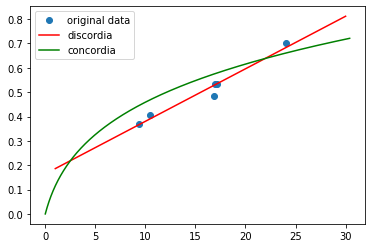

In [14]:
# для наглядности построим график с конкордией и дискордией
plt.plot(pu75, pu68, 'o', label='original data')
disc = np.linspace(1,30,29)
plt.plot(disc, intercept + slope*disc, 'r', label='discordia')
plt.plot(conc_x,conc_y, 'g', label='concordia')
plt.legend()
plt.show()

## Поиск точек пересечения с прямой

Нам нужно найти пересечение дискордии и конкордии. Это решается аналитически -- напишем уравнение. 

У нас есть функциональная зависимость x(t) и y(t):  
$x = e^{\lambda_{235}t}-1$  
$y = e^{\lambda_{238}t}-1$


Также у нас есть функциональная зависимость для линейной регрессии. 
$y = k \cdot x + b$

Подставим выражения для x(t) и y(t) в уравнение выше:  
$e^{\lambda_{238}t}-1 = k \cdot (e^{\lambda_{235}t}-1) + b$

Итого получаем  
$ f(t) = e^{\lambda_{238}t}-1 - k \cdot (e^{\lambda_{235}t}-1) - b = 0 $

Графически это выглядит так -- выпуклая функция с двумя корнями:

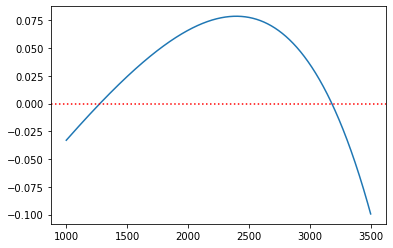

In [17]:
def age_f(t):
    return np.exp(lam_238*t) - 1 - slope*(np.exp(lam_235*t) - 1) - intercept

age = np.linspace(1000, 3500, 2500)
values = age_f(age)
plt.plot(age, values)
plt.axhline(y=0, color='r', linestyle='dotted')

Проблема в том, что алгоритм bisect (половинное деление) может искать корни, только в тех промежутках, где значения функции имеют противоположный знак. Это означает, что для каждого корня в процедуре нужно задать интервал поиска корней.

Разбить весь временной интервал на 2 промежутка проще всего по максимуму функции. В итоге мы получим два промежутка:

($0;t_{max}$) и ($t_{max};4500$)

Для поиска $t_{max}$ возьмем производную от $ f(t) = e^{\lambda_{238}t}-1 - k \cdot (e^{\lambda_{235}t}-1) - b$:

$ \lambda_{238} \cdot e^{\lambda_{238} t_{max}} - k \cdot \lambda_{235} \cdot e^{\lambda_{235} t_{max}} = 0 $

Решение уравнения от $t_{max}$:

$ t_{max} = \frac{ln \lambda_{238} - ln (\lambda_{235} \cdot k)}{\lambda_{235} - \lambda_{238}} $

Теперь используем $t_{max}$ для определения промежутков поиска корней уравнения:


In [19]:
t_max = (np.log(lam_238) - np.log(slope*lam_235)) / (lam_235 - lam_238)

sol1 = optimize.root_scalar(age_f, bracket=[t_max, 4500], method='bisect')
sol2 = optimize.root_scalar(age_f, bracket=[0, t_max], method='bisect')
print("upper: %f    lower: %f" % (sol1.root, sol2.root))

upper: 3181.604846    lower: 1275.558608
